In [184]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
INTERMEDIATE_DATA_FOLDER = Path("../data/02_intermediate")
import sys  
sys.path.insert(1, '../')
from util import mapped_to_snomed

In [39]:
abnormal = nx.read_gml(INTERMEDIATE_DATA_FOLDER / "abnormal.gml.gz")
print(G.nodes["HP:0010281"])

{'name': 'Cleft lower lip', 'def': '"A gap in the lower lip." [https://orcid.org/0000-0002-0736-9199]', 'subset': ['hposlim_core'], 'synonym': ['"Cleft lower lip" EXACT layperson []', '"Cleft of the lower lip" EXACT layperson []', '"Lower labial cleft" EXACT [https://orcid.org/0000-0001-5889-4463]'], 'xref': ['UMLS:C1856026'], 'is_a': ['HP:0000178', 'HP:0410030'], 'property_value': ['terms:creator https://orcid.org/0000-0002-0736-9199'], 'creation_date': '2009-07-12T09:50:34Z', 'M': 0, 'shortest_path_to_abnormal_id': ['HP:0000118', 'HP:0002664', 'HP:0011793', 'HP:0100604', 'HP:0000159', 'HP:0410030', 'HP:0010281'], 'L': 1, 'I': 0, 'T': 1}


### Relative depth of SNOMED CT mapped nodes

Here we compare the density of HPO abnormal-descendant concepts per depth level in the hierarchy tree. This is useful in having an idea of the distribution of mapped concepts. 

In [40]:
mapped, _ = mapped_to_snomed(abnormal)
abnormal_mapped = abnormal.subgraph(mapped)

In [41]:
MAX_LEVEL = 16
levels = {0: ["HP:0000118"]}
levels_mapped = {0: ["HP:0000118"]}
for level in range(1, MAX_LEVEL):
    levels[level] = [f for n in levels[level-1] for f, t in abnormal.in_edges(n)]
    levels_mapped[level] = [n for n in levels[level] if n in abnormal_mapped]

for l in range(0, 16):
    print(l, len(levels[l]), len(levels_mapped[l]), len(levels_mapped[l]) / len(levels[l]))

0 1 1 1.0
1 23 9 0.391304347826087
2 159 42 0.2641509433962264
3 942 220 0.23354564755838642
4 2967 778 0.26221772834512974
5 5958 1533 0.25730110775427995
6 7741 1585 0.2047539077638548
7 10246 1464 0.1428850283037283
8 15212 1015 0.06672363923218512
9 15933 522 0.03276219167765016
10 14548 211 0.014503711850426175
11 11660 61 0.00523156089193825
12 6981 6 0.0008594757198109154
13 2021 5 0.002474022761009401
14 140 0 0.0
15 38 0 0.0


/var/folders/c9/sn8rh64d37x2qwhhnvp5qq8m0000gn/T/ipykernel_89565/2045717562.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(range(1, 16));


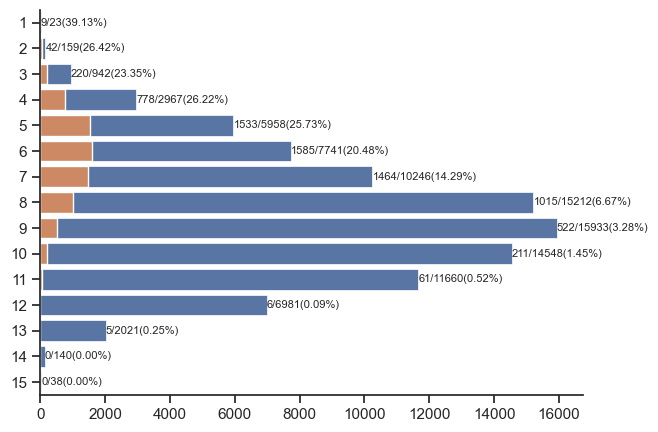

In [83]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
lengths = [len(ns) for l, ns in levels.items() if l !=0]
lengths_mapped = [len(ns) for l, ns in levels_mapped.items() if l !=0]
ax = sns.barplot(lengths, orient="h", log_scale=False, linewidth=.5,)
sns.barplot(lengths_mapped,  orient="h", log_scale=False)
ax.bar_label(ax.containers[0], 
            labels=[f"{lm}/{l}({lm/l:.2%})" for l, lm in zip(lengths, lengths_mapped)], 
            fontsize=8);
ax.set_yticklabels(range(1, 16));
ax;

### Multi-mapped nodes

### Structure of the subgraphs

In [85]:
deg_cent = [(key, value) for key, value in nx.betweenness_centrality(abnormal).items()]
sorted(deg_cent, key=lambda n: n[1], reverse=True)[:5]

[('HP:0002813', 2.7756979398637274e-05),
 ('HP:0011297', 2.1874403927130985e-05),
 ('HP:0001167', 1.8306380461553647e-05),
 ('HP:0001780', 1.6677493659042047e-05),
 ('HP:0000924', 1.329619400164622e-05)]

<Axes: ylabel='Count'>

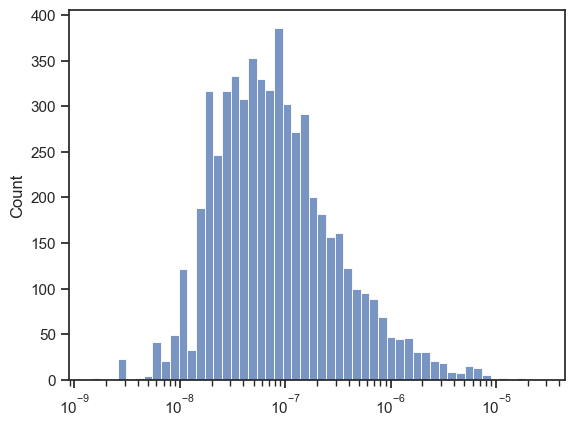

In [87]:
sns.histplot([n[1] for n in deg_cent], log_scale=True)

### Analysis of terminal nodes

In [96]:
terminal = abnormal.subgraph(nodes=[n for n in abnormal if abnormal.nodes[n]["T"]])
print(len(terminal.nodes))
terminal_sgs = list(nx.weakly_connected_components(terminal))
print(len(terminal_sgs), len([sg for sg in terminal_sgs if len(sg) > 100]))

13691
6388 4


<Axes: ylabel='Count'>

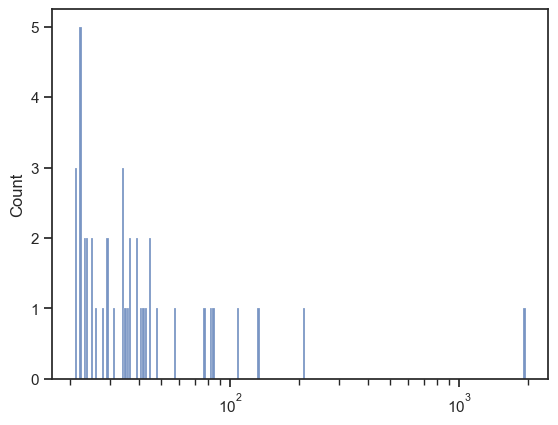

In [100]:
sns.histplot([len(sg) for sg in terminal_sgs if len(sg)>20], log_scale=True, bins=200)

Lets explore the largest terminal subcomponent.

In [ ]:
terminal_sgs = sorted(terminal_sgs, key=lambda sg: len(sg), reverse=True)
largest_terminal_sg = abnormal.subgraph(terminal_sgs[0])
len(largest_terminal_sg), nx.is_directed_acyclic_graph(largest_terminal_sg)

(1953, True)

In [ ]:
roots = [n for n in largest_terminal_sg if largest_terminal_sg.out_degree(n) == 0]
len([largest_terminal_sg.nodes[n]["name"] for n in roots])

125

In [175]:
subgroups = {r: nx.ancestors(largest_terminal_sg, r) for r in roots}
sg_lens = {r: len(list(sg)) for r, sg in subgroups.items()}
sorted(sg_lens.items(), key=lambda x: x[1], reverse=True)[-20:]

[('HP:0003971', 3),
 ('HP:0005929', 3),
 ('HP:0100339', 2),
 ('HP:0040034', 2),
 ('HP:0005054', 2),
 ('HP:0010672', 2),
 ('HP:0030314', 2),
 ('HP:0040035', 2),
 ('HP:0004262', 2),
 ('HP:0009657', 2),
 ('HP:0009654', 2),
 ('HP:0008363', 2),
 ('HP:0003957', 1),
 ('HP:0001783', 1),
 ('HP:0003051', 1),
 ('HP:0003053', 1),
 ('HP:0008119', 1),
 ('HP:0006155', 1),
 ('HP:0001504', 1),
 ('HP:0001230', 1)]

In [237]:
print(
    np.mean([len(largest_terminal_sg.nodes[n]['shortest_path_to_abnormal_id'])
            for n in largest_terminal_sg.nodes]), 
np.std([len(largest_terminal_sg.nodes[n]['shortest_path_to_abnormal_id'] )
            for n in largest_terminal_sg.nodes])
)

7.704557091653866 1.1210706977766183


### Analysis of intermediate nodes

In [201]:
intermediate = abnormal.subgraph(nodes=[n for n in abnormal if abnormal.nodes[n]["I"]])
print(len(intermediate.nodes))
intermediate_sgs = list(nx.weakly_connected_components(intermediate))
print(len(intermediate_sgs), len([sg for sg in intermediate_sgs if len(sg) > 0]))
print(np.median([len(sg) for sg in intermediate_sgs]), np.mean([len(sg) for sg in intermediate_sgs]))

1397
278 278
1.0 5.025179856115108


<Axes: ylabel='Count'>

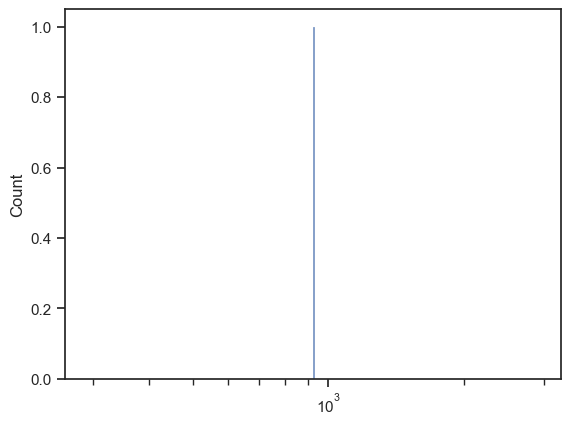

In [200]:
sns.histplot([len(sg) for sg in intermediate_sgs if len(sg)>15], log_scale=True, bins=200)

In [208]:
sorted([[sg, len(sg)] for sg in intermediate_sgs], key=lambda x: x[1], reverse=True)[0]

[{'HP:0000002',
  'HP:0000008',
  'HP:0000009',
  'HP:0000014',
  'HP:0000022',
  'HP:0000025',
  'HP:0000032',
  'HP:0000036',
  'HP:0000045',
  'HP:0000050',
  'HP:0000055',
  'HP:0000056',
  'HP:0000058',
  'HP:0000066',
  'HP:0000069',
  'HP:0000078',
  'HP:0000079',
  'HP:0000080',
  'HP:0000118',
  'HP:0000140',
  'HP:0000141',
  'HP:0000142',
  'HP:0000152',
  'HP:0000157',
  'HP:0000159',
  'HP:0000163',
  'HP:0000168',
  'HP:0000172',
  'HP:0000174',
  'HP:0000177',
  'HP:0000190',
  'HP:0000223',
  'HP:0000234',
  'HP:0000235',
  'HP:0000236',
  'HP:0000240',
  'HP:0000245',
  'HP:0000256',
  'HP:0000264',
  'HP:0000277',
  'HP:0000286',
  'HP:0000290',
  'HP:0000301',
  'HP:0000309',
  'HP:0000315',
  'HP:0000326',
  'HP:0000383',
  'HP:0000415',
  'HP:0000422',
  'HP:0000429',
  'HP:0000433',
  'HP:0000436',
  'HP:0000481',
  'HP:0000492',
  'HP:0000499',
  'HP:0000502',
  'HP:0000504',
  'HP:0000525',
  'HP:0000532',
  'HP:0000534',
  'HP:0000539',
  'HP:0000553',
  'HP:00

In [216]:
intermediate_sgs = sorted(intermediate_sgs, key=lambda sg: len(sg), reverse=True)
largest_intermediate_sg = abnormal.subgraph(intermediate_sgs[0])
roots = [n for n in largest_intermediate_sg if largest_intermediate_sg.out_degree(n) == 0]
len([largest_intermediate_sg.nodes[n]["name"] for n in roots])

47

In [228]:
np.random.choice([largest_intermediate_sg.nodes[n]["name"] for n in roots], 10)

array(['Intestinal hypoplasia', 'Abnormality of the tonsils',
       'Organic aciduria', 'Abnormal oral morphology',
       'Abnormality of the pineal gland', 'Phenotypic abnormality',
       'Abnormality of the genital system', 'Abnormality of the calf',
       'Recurrent skin infections', 'Abnormality of the tongue'],
      dtype='<U55')

In [232]:
# ABNORMAL_HPO_ID = "HP:0000118"  # Phenotypic abnormality
# paths_to_root = [nx.shortest_path(abnormal.to_undirected(as_view=True), 
#     ABNORMAL_HPO_ID, n) 
#     for n in largest_intermediate_sg.nodes]
# np.mean([len(p) for p in paths_to_root]), np.std([len(p) for p in paths_to_root])
np.mean([len(largest_intermediate_sg.nodes[n]['shortest_path_to_abnormal_id'])
            for n in largest_intermediate_sg.nodes])

np.float64(5.410810810810811)